In [1]:
# Jupyter Notebook: Dropout Placement Experiments on CIFAR-100 ResNet

# Imports & Configuration
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd

# reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [8]:
# Experiment settings
variants = ["standard", "pre_relu", "post_add", "mixed"]
dropout_rates = [0.1]    #[0.1, 0.3, 0.5]
num_epochs = 30
batch_size = 128
seeds = [42]    #[0, 1, 2]

In [9]:
# Model Definition (ResNet-18 with Dropout Variants)
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1, dropout_p=0.3, variant="standard"):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, 3, stride, 1, bias=False)
        self.bn1   = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, 3, 1, 1, bias=False)
        self.bn2   = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, 1, stride, bias=False),
                nn.BatchNorm2d(planes)
            )
        self.dropout = nn.Dropout(p=dropout_p)
        self.variant = variant

    def forward(self, x):
        out = self.conv1(x); out = self.bn1(out)
        if self.variant in ("pre_relu","mixed"): out = self.dropout(out)
        out = F.relu(out)
        out = self.conv2(out); out = self.bn2(out)
        if self.variant in ("standard","mixed"): out = self.dropout(out)
        out += self.shortcut(x)
        if self.variant=="post_add": out = self.dropout(out)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, variant, dropout_p):
        super().__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3,64,3,1,1,bias=False)
        self.bn1   = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(64,2,1,dropout_p,variant)
        self.layer2 = self._make_layer(128,2,2,dropout_p,variant)
        self.layer3 = self._make_layer(256,2,2,dropout_p,variant)
        self.layer4 = self._make_layer(512,2,2,dropout_p,variant)
        self.linear = nn.Linear(512,100)
    def _make_layer(self, planes, blocks, stride, dp, var):
        strides = [stride] + [1]*(blocks-1)
        layers = []
        for s in strides:
            layers.append(BasicBlock(self.in_planes, planes, s, dp, var))
            self.in_planes = planes
        return nn.Sequential(*layers)
    def forward(self,x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out); out = self.layer2(out)
        out = self.layer3(out); out = self.layer4(out)
        out = F.adaptive_avg_pool2d(out,1).view(out.size(0),-1)
        return self.linear(out)

In [10]:
# Data Loaders
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071,0.4867,0.4408),
                         (0.2675,0.2565,0.2761)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071,0.4867,0.4408),
                         (0.2675,0.2565,0.2761)),
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                         download=True, transform=transform_train)
testset  = torchvision.datasets.CIFAR100(root='./data', train=False,
                                         download=True, transform=transform_test)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader  = torch.utils.data.DataLoader(testset,  batch_size=batch_size,
                                          shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
# Training & Evaluation Functions
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    correct = total = 0
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, target)
        loss.backward(); optimizer.step()
        _, pred = out.max(1)
        correct += pred.eq(target).sum().item()
        total += target.size(0)
    return 100.*correct/total

def eval_epoch(model, loader, criterion):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            out = model(data)
            _, pred = out.max(1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)
    return 100.*correct/total

In [12]:
# Run Experiments & Collect Metrics
results = {}
for var in variants:
    for dp in dropout_rates:
        key = f"{var}_p{dp}"
        results[key] = {"train_acc": [], "test_acc": []}
        
        for seed in seeds:
            set_seed(seed)
            print(f"\n>>> Starting {key}, seed={seed} <<<")
            
            model = ResNet(var, dp).to(device)
            optimizer = optim.SGD(model.parameters(), lr=0.1,
                                  momentum=0.9, weight_decay=5e-4)
            scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                                       [50,75], 0.1)
            criterion = nn.CrossEntropyLoss()
            
            train_accs, test_accs = [], []
            for epoch in range(1, num_epochs + 1):
                ta = train_epoch(model, trainloader, optimizer, criterion)
                te = eval_epoch(model, testloader, criterion)
                scheduler.step()
                
                train_accs.append(ta)
                test_accs.append(te)
                
                # Print progress at epoch 1, every 10 epochs, and final epoch
                if epoch == 1 or epoch % 10 == 0 or epoch == num_epochs:
                    print(f"    Epoch {epoch:3d}/{num_epochs} | "
                          f"train_acc={ta:5.2f}% | test_acc={te:5.2f}%")
            
            results[key]["train_acc"].append(train_accs)
            results[key]["test_acc"].append(test_accs)
        
        print(f"<<< Finished variant={var}, dropout={dp} >>>\n")



>>> Starting standard_p0.1, seed=42 <<<
    Epoch   1/30 | train_acc= 7.03% | test_acc=10.46%
    Epoch  10/30 | train_acc=54.92% | test_acc=49.06%
    Epoch  20/30 | train_acc=63.50% | test_acc=56.39%
    Epoch  30/30 | train_acc=65.94% | test_acc=56.66%
<<< Finished variant=standard, dropout=0.1 >>>


>>> Starting pre_relu_p0.1, seed=42 <<<
    Epoch   1/30 | train_acc= 7.73% | test_acc=12.03%
    Epoch  10/30 | train_acc=54.36% | test_acc=47.37%
    Epoch  20/30 | train_acc=63.21% | test_acc=53.61%
    Epoch  30/30 | train_acc=65.70% | test_acc=55.05%
<<< Finished variant=pre_relu, dropout=0.1 >>>


>>> Starting post_add_p0.1, seed=42 <<<
    Epoch   1/30 | train_acc= 7.26% | test_acc=10.80%
    Epoch  10/30 | train_acc=54.19% | test_acc=45.88%
    Epoch  20/30 | train_acc=61.78% | test_acc=51.52%
    Epoch  30/30 | train_acc=64.79% | test_acc=57.65%
<<< Finished variant=post_add, dropout=0.1 >>>


>>> Starting mixed_p0.1, seed=42 <<<
    Epoch   1/30 | train_acc= 7.77% | test_acc=

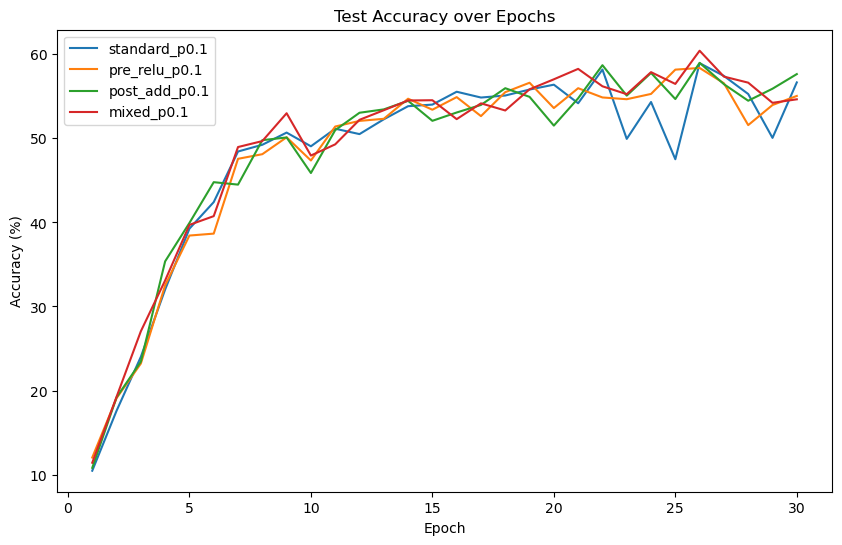

In [13]:
# Plot Accuracy Curves with Error Bands
plt.figure(figsize=(10,6))
for key, data in results.items():
    train_arr = np.array(data["train_acc"])  # seeds x epochs
    test_arr  = np.array(data["test_acc"])
    mean_test = test_arr.mean(axis=0)
    std_test  = test_arr.std(axis=0)
    epochs = np.arange(1, num_epochs+1)
    plt.plot(epochs, mean_test, label=key)
    plt.fill_between(epochs, mean_test-std_test, mean_test+std_test, alpha=0.2)
plt.title("Test Accuracy over Epochs")
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)")
plt.legend(); plt.show()

In [14]:
# Generalization Gap Table at Final Epoch
gap_data = []
for key, data in results.items():
    train_final = np.array(data["train_acc"])[:,-1].mean()
    test_final  = np.array(data["test_acc"])[:,-1].mean()
    gap_data.append({"Variant": key, 
                     "Train Acc": train_final, 
                     "Test Acc": test_final,
                     "Gap": train_final-test_final})
gap_df = pd.DataFrame(gap_data).sort_values("Gap")
gap_df

,Variant,Train Acc,Test Acc,Gap
2,post_add_p0.1,64.786,57.65,7.136
0,standard_p0.1,65.936,56.66,9.276
3,mixed_p0.1,64.760,54.65,10.110
1,pre_relu_p0.1,65.704,55.05,10.654


Pre-ReLU mean/var: -0.3494361 1.0210454
Post-ReLU mean/var: -0.032342393 0.11117366


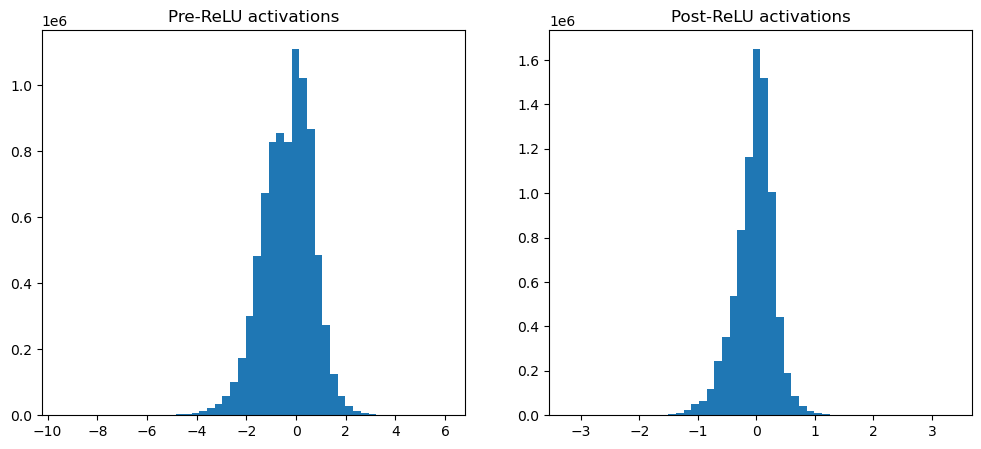

In [16]:
# Activation Statistics in First Residual Block
activation_stats = []
def get_acts(name):
    def hook(module, inp, out):
        activation_stats.append((name, inp[0].detach().cpu().numpy(), out.detach().cpu().numpy()))
    return hook

# register hook on first block
model.layer1[0].bn1.register_forward_hook(get_acts("block1"))

# run one batch through model
data, _ = next(iter(testloader))
_ = model(data.to(device))

# compute means/vars
pre_relu = activation_stats[0][1].ravel()
post_relu = activation_stats[0][2].ravel()
print("Pre-ReLU mean/var:", pre_relu.mean(), pre_relu.var())
print("Post-ReLU mean/var:", post_relu.mean(), post_relu.var())

# plot histograms
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(pre_relu, bins=50); plt.title("Pre-ReLU activations")
plt.subplot(1,2,2)
plt.hist(post_relu, bins=50); plt.title("Post-ReLU activations")
plt.show()
